# **Clickbait Sentence Classification using Bidirectional LSTM**
evaluation score (+-) : loss: 0.5411 - accuracy: 0.7607

## Library

In [1]:
# !pip install -q -U keras-tuner

In [2]:
# !pip install tensorflowjs

In [3]:
# file operation
from google.colab import files
import pandas as pd
import zipfile
import os

# preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, Embedding, LSTM, Normalization
from tensorflow.keras.optimizers import Adam

# visualization
import matplotlib.pyplot as plt

# other
import numpy as np
from tensorflow import constant
# import keras_tuner as kt
import tensorflow as tf

## Getting Dataset Ready

In [4]:
# upload file (must .zip file)
uploaded = files.upload()

# name of the file
list(uploaded.keys())[0]

Saving data-sekunder-clickbait.zip to data-sekunder-clickbait.zip


'data-sekunder-clickbait.zip'

In [5]:
# unzipping file
local_zip = os.path.join('./', list(uploaded.keys())[0])
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
# reviewing filename
base_dir = local_zip[:-4]
filenames = os.listdir(base_dir)
filenames

['annotated_okezone.csv',
 'annotated_sindonews.csv',
 'annotated_tribunnews.csv',
 'annotated_liputan6.csv',
 'annotated_kompas.csv',
 'annotated_tempo.csv',
 'annotated_detikNews.csv',
 'annotated_kapanlagi.csv',
 'annotated_fimela.csv',
 'annotated_republika.csv',
 'annotated_wowkeren.csv',
 'annoated_pos_metro.csv']

In [7]:
# reviewing dataframe
df = pd.read_csv(os.path.join(base_dir, filenames[0]))
df

,title,label,label_score
0,Ini Penyebab Jamaah Tertipu Penggunaan Visa No...,clickbait,1
1,"Balita di Bogor Tewas dengan Luka Lebam, Ibu T...",non-clickbait,0
2,"Demi Keadilan, Pria Ini Habiskan Rp526 Juta La...",clickbait,1
3,Claudia Emanuela Santoso Harumkan Indonesia di...,non-clickbait,0
4,"Kalah Saing di Monza, Bottas Akui Ketangguhan ...",non-clickbait,0
...,...,...,...
1495,"Tampil Perkasa, Timnas Indonesia U-16 Libas Ma...",clickbait,1
1496,Polda Kalsel Sudah Petakan Titik Api Kebakaran...,non-clickbait,0
1497,Wall Street Dibuka Melemah Imbas Laba FedEx Te...,non-clickbait,0
1498,"Diperiksa 4 Jam, Pelapor Pendiri Kaskus Diceca...",clickbait,1


In [8]:
# concat dataframe
df = pd.DataFrame()
for filename in filenames:
  another_df = pd.read_csv(os.path.join(base_dir, filename))
  df = pd.concat([df, another_df], ignore_index=True)

# reviewing concatenated dataframe
df

,title,label,label_score
0,Ini Penyebab Jamaah Tertipu Penggunaan Visa No...,clickbait,1
1,"Balita di Bogor Tewas dengan Luka Lebam, Ibu T...",non-clickbait,0
2,"Demi Keadilan, Pria Ini Habiskan Rp526 Juta La...",clickbait,1
3,Claudia Emanuela Santoso Harumkan Indonesia di...,non-clickbait,0
4,"Kalah Saing di Monza, Bottas Akui Ketangguhan ...",non-clickbait,0
...,...,...,...
14995,Siap-siap! Jalan Tol Dalam Kota di Medan Seger...,clickbait,1
14996,"Cemburu ke Istri Pertama, Istri Kedua Gantung ...",clickbait,1
14997,"Nyamar Jadi Emak Emak Berdaster, Polisi Ini Be...",clickbait,1
14998,Aktivis HAM Temukan Fakta Mengerikan dalam Pid...,clickbait,1


In [9]:
# renaming and droping useless column
df.rename(columns={'label_score':'clickbait'}, inplace = True)
df.drop('label', axis=1, inplace=True, errors='ignore')

# reviewing dataframe
df

,title,clickbait
0,Ini Penyebab Jamaah Tertipu Penggunaan Visa No...,1
1,"Balita di Bogor Tewas dengan Luka Lebam, Ibu T...",0
2,"Demi Keadilan, Pria Ini Habiskan Rp526 Juta La...",1
3,Claudia Emanuela Santoso Harumkan Indonesia di...,0
4,"Kalah Saing di Monza, Bottas Akui Ketangguhan ...",0
...,...,...
14995,Siap-siap! Jalan Tol Dalam Kota di Medan Seger...,1
14996,"Cemburu ke Istri Pertama, Istri Kedua Gantung ...",1
14997,"Nyamar Jadi Emak Emak Berdaster, Polisi Ini Be...",1
14998,Aktivis HAM Temukan Fakta Mengerikan dalam Pid...,1


In [10]:
# search for missing values
print('Title column missing values')
print(df[pd.isnull(df['title'])].count(), '\n')
print('Clickbait column missing values')
print(df[pd.isnull(df['clickbait'])].count())

Title column missing values
title        0
clickbait    1
dtype: int64 

Clickbait column missing values
title        0
clickbait    0
dtype: int64


In [11]:
# removing missing values
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# reviewing dataframe after removing missing values
df

,title,clickbait
0,Ini Penyebab Jamaah Tertipu Penggunaan Visa No...,1
1,"Balita di Bogor Tewas dengan Luka Lebam, Ibu T...",0
2,"Demi Keadilan, Pria Ini Habiskan Rp526 Juta La...",1
3,Claudia Emanuela Santoso Harumkan Indonesia di...,0
4,"Kalah Saing di Monza, Bottas Akui Ketangguhan ...",0
...,...,...
14994,Siap-siap! Jalan Tol Dalam Kota di Medan Seger...,1
14995,"Cemburu ke Istri Pertama, Istri Kedua Gantung ...",1
14996,"Nyamar Jadi Emak Emak Berdaster, Polisi Ini Be...",1
14997,Aktivis HAM Temukan Fakta Mengerikan dalam Pid...,1


In [12]:
# search for duplicate rows in title column
print(df['title'].describe(), '\n')
print('Duplicate Rows:')
print(df[df.duplicated(subset='title', keep=False)].count())

count                                                 14999
unique                                                14968
top       Atasi Kabut Asap dari Indonesia, Malaysia Renc...
freq                                                      3
Name: title, dtype: object 

Duplicate Rows:
title        59
clickbait    59
dtype: int64


In [13]:
# reviewing duplicates rows
duplicates = df[df.duplicated(subset='title', keep=False)]
duplicates

,title,clickbait
342,Jadwal MotoGP Aragon 2019,0
585,Pemerintah Tetapkan Rencana Kebijakan Cukai Ha...,1
1362,DPR Bentuk Pansus Pemindahan Ibu Kota,0
1810,DPD Rekomendasikan 15 Nama Calon Anggota BPK,0
1850,"Kekeringan Lebih Lama, Kementan Terus Upayakan...",0
1873,Industri Asuransi Optimistis Kembangkan Pasar ...,0
1905,Atalia Praratya Apresiasi Program Pencanangan ...,0
1939,Industri Asuransi Optimistis Kembangkan Pasar ...,0
2215,Kemkominfo Sosialisasikan Manfaat Bantuan Sosi...,0
2443,Jadwal MotoGP Aragon 2019,0


In [14]:
# drop duplicate rows
df.drop_duplicates(subset='title', keep=False, inplace=True)
df.reset_index(inplace=True, drop=True)

# reviewing dataframe after removing duplicates
print(df['title'].describe(), '\n')
print('Duplicate Rows:')
print(df[df.duplicated(subset='title', keep=False)].count())

count                                                 14940
unique                                                14940
top       Ini Penyebab Jamaah Tertipu Penggunaan Visa No...
freq                                                      1
Name: title, dtype: object 

Duplicate Rows:
title        0
clickbait    0
dtype: int64


## Data Preprocesing

In [15]:
# train test split + shuffle
train_sentences, test_sentences, train_labels, test_labels = train_test_split(np.array(df['title']), np.array(df['clickbait']), test_size=0.2, random_state=1)

# removing front and back whitespace in sentences
train_sentences = [sentence.strip() for sentence in train_sentences]
test_sentences = [sentence.strip() for sentence in test_sentences]

# visualizing result
for i in range(100, 110):
  print(train_labels[i], '\t', train_sentences[i])

print('\nThe amount of data classify as clickbait before splitting:', len([label for label in df['clickbait'] if label == 1]) / len(df['clickbait']))
print('The amount of sentences classify as clickbait in train label after splitting:', len([label for label in train_labels if label == 1]) / len(train_labels))

1 	 Menko Luhut: Traveloka Bantu Promosikan Destinasi Wisata Prioritas
1 	 Liga Champions, Inter vs Slavia Praha Jadi Ajang Debut Kostum Ketiga Inter Milan, Dedikasi Pirelli
1 	 Resep Ayam Coca Cola, Ide Bekal Tak Biasa
1 	 Motivasi Tinggi Fabio Quartararo Hadapi Balapan MotoGP San Marino 2019
0 	 Polisi Siapkan Rute Iring-iringan Jenazah BJ Habibie
1 	 Lebby Wilayati Dinilai Lebih Pantas Ikutan 'Puteri Indonesia' Dibanding Rosa Meldianti, Setuju?
1 	 PKS: Pasal Penghinaan Presiden Bisa Jadi 'Pasal Karet'
0 	 Cuaca Jakarta Cerah di Awal Pekan
1 	 Baekhyun EXO Bikin Banyak Orang Iri Gara-Gara Sifatnya Ini
1 	 Setelah Bertengkar, Lucinta Luna dan Raffi Ahmad Foto Bareng

The amount of data classify as clickbait before splitting: 0.41974564926372154
The amount of sentences classify as clickbait in train label after splitting: 0.42336010709504684


In [16]:
# hyperparameter
truncating_type = 'pre'
padding_type = 'pre'

# creating vocab (filters without ! and ?)
tokenizer = Tokenizer(filters='"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(train_sentences)

# tokenizing train and test data
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# other hyperparameter
sequences_maxlen = np.max([len(sequence) for sequence in train_sequences])
vocab_size = list(tokenizer.index_word)[-1]

print('vocab size:', vocab_size)
print('maximum sequence length:', sequences_maxlen)

vocab size: 17134
maximum sequence length: 20


In [17]:
# padding train and test sequences
train_sequences = pad_sequences(train_sequences, maxlen=sequences_maxlen, padding=padding_type, truncating=truncating_type)
test_sequences = pad_sequences(test_sequences, maxlen=sequences_maxlen, padding=padding_type, truncating=truncating_type)

In [18]:
# preprocessing result
temp = tokenizer.sequences_to_texts(train_sequences[100:110])
temp

['menko luhut traveloka bantu promosikan destinasi wisata prioritas',
 'liga champions inter vs slavia praha jadi ajang debut kostum ketiga inter milan dedikasi pirelli',
 'resep ayam coca cola ide bekal tak biasa',
 'motivasi tinggi fabio quartararo hadapi balapan motogp san marino 2019',
 'polisi siapkan rute iring iringan jenazah bj habibie',
 "lebby wilayati dinilai lebih pantas ikutan 'puteri indonesia' dibanding rosa meldianti setuju?",
 "pks pasal penghinaan presiden bisa jadi 'pasal karet'",
 'cuaca jakarta cerah di awal pekan',
 'baekhyun exo bikin banyak orang iri gara gara sifatnya ini',
 'setelah bertengkar lucinta luna dan raffi ahmad foto bareng']

In [19]:
# import pickle

# # saving tokenizer to pickle
# with open('tokenizer.pickle', 'wb') as handle:
#   pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading tokenizer
# with open('tokenizer.pickle', 'rb') as handle:
#   saved_tokenizer = pickle.load(handle)

# saved_tokenizer

In [20]:
# saving tokenizer into json format
import json

with open('tokenizer.json', 'w') as fp:
    json.dump(tokenizer.word_index, fp)

## Finding Best Learning Rate

In [21]:
model = Sequential([
  Embedding(vocab_size, 64, input_length=sequences_maxlen, name='embedding'),
  Bidirectional(LSTM(32, return_sequences=True, name='lstm1')),
  Bidirectional(LSTM(16, name='lstm2')),
  Dense(16, activation='relu', name='dense'),
  Dropout(0.2, name='dropout'),
  Dense(1, activation='sigmoid', name='output'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 64)            1096576   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           24832     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [22]:
num_epochs = 60

# Learning rate scheduler (finetune learning rate)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
  lambda epoch: 1e-6 * 10**(epoch/(num_epochs/4))
)

model.compile(
  optimizer=Adam(),
  loss='binary_crossentropy',
  metrics=['accuracy']
)

# model training
history = model.fit(
  train_sequences,
  train_labels,
  epochs=num_epochs,
  validation_split=0.2,
  callbacks=[lr_schedule],
  verbose=1
)

Epoch 1/60


KeyboardInterrupt: ignored

In [ ]:
# Define the learning rate array
lrs = 1e-6 * (10**(np.arange(num_epochs) / (num_epochs/4)))

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.semilogx(lrs, history.history["val_loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-5, 1e-4, .4, 1])

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["accuracy"])
plt.semilogx(lrs, history.history["val_accuracy"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-5, 1e-4, .6, 1])

In [ ]:
stop

## Train Model Using Best Learning Rate

In [36]:
model = Sequential([
  Embedding(vocab_size, 64, input_length=sequences_maxlen, name='embedding'),
  Bidirectional(LSTM(32, return_sequences=True, name='lstm1'), name='bidirectional1'),
  Bidirectional(LSTM(16, name='lstm2'), name='bidirectional2'),
  Dense(16, activation='relu', name='dense'),
  Dropout(0.2, name='dropout'),
  Dense(1, activation='sigmoid', name='output'),
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 64)            1096576   
                                                                 
 bidirectional1 (Bidirection  (None, 20, 64)           24832     
 al)                                                             
                                                                 
 bidirectional2 (Bidirection  (None, 32)               10368     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 output (Dense)              (None, 1)                

In [37]:
# early stopping callback
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# checkpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(
  filepath='/content/training_checkpoint/best',
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

model.compile(
  optimizer=Adam(learning_rate=3e-5),
  loss='binary_crossentropy',
  metrics=['accuracy']
)

# model training
history = model.fit(
  train_sequences,
  train_labels,
  epochs=60,
  validation_split=0.2,
  callbacks=[checkpoint],
  verbose=1
)

Epoch 1/60
299/299 [==============================] - 11s 19ms/step - loss: 0.6860 - accuracy: 0.5710 - val_loss: 0.6831 - val_accuracy: 0.5558
Epoch 2/60
299/299 [==============================] - 4s 13ms/step - loss: 0.6721 - accuracy: 0.5818 - val_loss: 0.6762 - val_accuracy: 0.5558
Epoch 3/60
299/299 [==============================] - 4s 12ms/step - loss: 0.6576 - accuracy: 0.5829 - val_loss: 0.6611 - val_accuracy: 0.5604
Epoch 4/60
299/299 [==============================] - 4s 13ms/step - loss: 0.6240 - accuracy: 0.6371 - val_loss: 0.6159 - val_accuracy: 0.6905
Epoch 5/60
299/299 [==============================] - 4s 13ms/step - loss: 0.5375 - accuracy: 0.7770 - val_loss: 0.5627 - val_accuracy: 0.7512
Epoch 6/60
299/299 [==============================] - 4s 13ms/step - loss: 0.4434 - accuracy: 0.8298 - val_loss: 0.5490 - val_accuracy: 0.7465
Epoch 7/60
299/299 [==============================] - 4s 13ms/step - loss: 0.3754 - accuracy: 0.8568 - val_loss: 0.5653 - val_accuracy: 0.746

In [38]:
# loading weights of training result
model.load_weights('/content/training_checkpoint/best')

## Evaluate model

In [39]:
model.evaluate(test_sequences, test_labels)

94/94 [==============================] - 1s 5ms/step - loss: 0.5505 - accuracy: 0.7503


[0.5505486130714417, 0.7503346800804138]

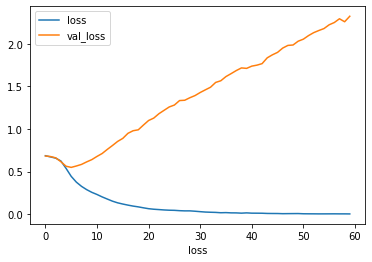

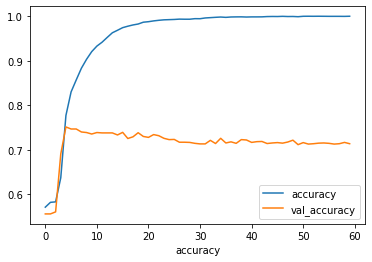

In [40]:
# training history
# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.xlabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# Plot the loss (zoom in)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.xlabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Saving Model

In [41]:
# save model into h5 format
model.save('/content/training_result/model.h5')

In [42]:
# # installing tfjs
# !pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
# save model into json format
!tensorflowjs_converter --input_format=keras /content/training_result/model.h5 /content/training_result/tfjs_model

In [44]:
# zipping model
!zip -r /content/training_result/tfjs_model.zip /content/training_result/tfjs_model

updating: content/training_result/tfjs_model/ (stored 0%)
updating: content/training_result/tfjs_model/group1-shard2of2.bin (deflated 8%)
updating: content/training_result/tfjs_model/group1-shard1of2.bin (deflated 8%)
updating: content/training_result/tfjs_model/model.json (deflated 81%)


In [45]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 64)            1096576   
                                                                 
 bidirectional1 (Bidirection  (None, 20, 64)           24832     
 al)                                                             
                                                                 
 bidirectional2 (Bidirection  (None, 32)               10368     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 output (Dense)              (None, 1)                